In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs, n_inputs = {}, len(x)
        model_kwargs['input_ids'] = x[0]
        if (n_inputs > 1 and self._include_arg('attention_mask', x[1])): model_kwargs['attention_mask'] = x[1]
        if (n_inputs > 2 and self._include_arg('token_type_ids', x[2])): model_kwargs['token_type_ids'] = x[2]
        if (n_inputs > 3 and self._include_arg('cls_index', x[3])): model_kwargs['cls_index'] = x[3]
        if (n_inputs > 4 and self._include_arg('p_mask', x[4])): model_kwargs['p_mask'] = x[4]
        
        return self.hf_model(**model_kwargs)

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """We need to return everything from the model for question/answer tasks"""
    def after_pred(self): self.learn.pred = self.pred

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
# full
# squad_df = pd.read_csv('./data/task-question-answering/squad_cleaned.csv'); len(squad_df)

# sample
squad_df = pd.read_csv('./squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start': [269]}",train,in the late 1990s,False
1,56be85543aeaaa14008c9065,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",What areas did Beyonce compete in when she was growing up?,"{'text': ['singing and dancing'], 'answer_start': [207]}",train,singing and dancing,False


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)

# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
214,56be97c73aeaaa14008c912a,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Beyonce would take a break from music in which year?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], beyonce, would, take, a, break, from, music, in, which, year, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, ballet...",99,23,24
215,56be97c73aeaaa14008c912b,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Which year did Beyonce and her father part business ways?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], which, year, did, beyonce, and, her, father, part, business, ways, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, b...",99,23,24


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'

hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len, 
                                 truncation_strategy=trunc_strat, 
                                 task=ForQuestionAnsweringTask())

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer
0,"where was chopin born? fryderyk chopin was born in zelazowa wola, 46 kilometres ( 29 miles ) west of warsaw, in what was then the duchy of warsaw, a polish state established by napoleon. the parish baptismal record gives his birthday as 22 february 1810, and cites his given names in the latin form fridericus franciscus ( in polish, he was fryderyk franciszek ). however, the composer and his family used the birthdate 1 march, [ n 2 ] which is now generally accepted as the correct date.","(14, 20)",zelazowa wola
1,"beyonce, during october 2014, partnered with whom to produce an outdoor line of clothing? in october 2014, beyonce signed a deal to launch an activewear line of clothing with british fashion retailer topshop. the 50 - 50 venture is called parkwood topshop athletic ltd and is scheduled to launch its first dance, fitness and sports ranges in autumn 2015. the line will launch in april 2016.","(39, 41)",topshop


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.7585775852203369)

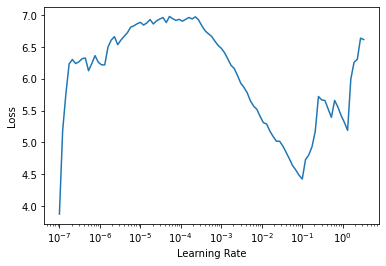

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.672189,3.098186,00:02
1,2.849362,2.410227,00:02
2,2.309987,2.294913,00:02


In [ ]:
#export
@typedispatch
def show_results(x:HF_QuestionAnswerInput, y, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    res = L()
    for inp, start, end, pred in zip(x[0], *y, outs):
        txt = hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')
        ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        res.append((txt,
                       (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                       (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(res, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what is beyonce's percentage of ownership in the new venture? in october 2014, beyonce signed a deal to launch an activewear line of clothing with british fashion retailer topshop. the 50 - 50 venture is called parkwood topshop athletic ltd and is scheduled to launch its first dance, fitness and sports ranges in autumn 2015. the line will launch in april 2016.","(39, 40)",50,"(39, 41)",50 -
1,"what was angela merkel serving as in relation to the letter? in 2015 beyonce signed an open letter which the one campaign had been collecting signatures for ; the letter was addressed to angela merkel and nkosazana dlamini - zuma, urging them to focus on women as they serve as the head of the g7 in germany and the au in south africa respectively, which will start to set the priorities in development funding before a main un summit in september 2015 that will establish new development goals for the generation.","(62, 70)",the head of the g7 in germany,"(63, 77)",head of the g7 in germany and the au in south africa respectively


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '12'),
 tensor([11]),
 tensor([[3.9383e-08, 8.6692e-08, 3.0271e-09, 8.4665e-09, 4.6643e-09, 4.2751e-09,
          1.8876e-10, 3.9386e-08, 6.6853e-05, 3.0912e-06, 2.3555e-04, 9.9964e-01,
          1.8816e-05, 3.1252e-07, 3.0238e-06, 3.9745e-08, 1.4765e-05, 1.3356e-05,
          2.4110e-08, 3.0127e-06, 1.7599e-07, 3.9377e-08, 3.9537e-08, 1.2657e-10,
          1.4502e-10, 1.3354e-10, 1.3280e-10, 1.3624e-10, 1.4135e-10, 1.3798e-10,
          1.2797e-10, 1.3418e-10, 1.3989e-10, 1.3847e-10, 1.2248e-10, 1.1921e-10,
          1.2692e-10, 1.2644e-10, 1.1978e-10, 1.2075e-10, 1.2235e-10, 1.2673e-10,
          1.3012e-10, 1.2576e-10, 1.3135e-10, 1.3334e-10, 1.3015e-10, 1.2673e-10,
          1.2831e-10, 1.2975e-10, 1.3681e-10, 1.3325e-10, 1.3238e-10, 1.3549e-10,
          1.4388e-10, 1.4250e-10, 1.3468e-10, 1.3032e-10, 1.3282e-10, 1.4469e-10,
          1.4163e-10, 1.2991e-10, 1.2492e-10, 1.3004e-10, 1.3967e-10, 1.2819e-10,
          1.2329e-10, 1.2787e-10, 1.2863e-10, 1.3835e-10, 1.2793e-10

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.745025,1.971312,00:08
1,1.434446,1.665559,00:08
2,1.272212,1.609982,00:08


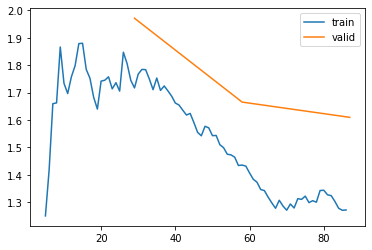

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what is beyonce's percentage of ownership in the new venture? in october 2014, beyonce signed a deal to launch an activewear line of clothing with british fashion retailer topshop. the 50 - 50 venture is called parkwood topshop athletic ltd and is scheduled to launch its first dance, fitness and sports ranges in autumn 2015. the line will launch in april 2016.","(39, 40)",50,"(39, 42)",50 - 50
1,"what language does she mainly sing? beyonce's music is generally r & b, but she also incorporates pop, soul and funk into her songs. 4 demonstrated beyonce's exploration of 90s - style r & b, as well as further use of soul and hip hop than compared to previous releases. while she almost exclusively releases english songs, beyonce recorded several spanish songs for irreemplazable ( re - recordings of songs from b'day for a spanish - language audience ), and the re - release of b'day. to record these, beyonce was coached phonetically by american record producer rudy perez.","(67, 68)",english,"(67, 69)",english songs


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[6.8019e-08, 1.2326e-07, 1.1366e-08, 7.7229e-09, 3.9524e-09, 2.6323e-08,
          1.8820e-09, 6.8023e-08, 3.0512e-06, 5.2081e-07, 4.4731e-06, 5.6266e-06,
          1.0524e-07, 8.6806e-04, 9.9912e-01, 8.5079e-08, 5.9578e-08, 6.4719e-08,
          2.9984e-09, 3.7898e-08, 3.1712e-08, 6.8005e-08, 6.8078e-08, 3.6189e-10,
          4.3248e-10, 3.9664e-10, 3.9415e-10, 3.8516e-10, 3.9853e-10, 3.6648e-10,
          3.6833e-10, 3.6913e-10, 4.2003e-10, 4.1970e-10, 3.6461e-10, 3.5798e-10,
          3.6599e-10, 3.6077e-10, 3.5771e-10, 3.6588e-10, 3.4839e-10, 3.5584e-10,
          3.6983e-10, 3.6221e-10, 3.6067e-10, 3.7195e-10, 3.5115e-10, 3.5471e-10,
          3.6190e-10, 3.5270e-10, 4.0910e-10, 3.7959e-10, 3.7232e-10, 3.7783e-10,
          3.8064e-10, 3.9390e-10, 3.6674e-10, 3.6750e-10, 3.6379e-10, 4.2995e-10,
          4.2877e-10, 3.7806e-10, 3.6920e-10, 3.6974e-10, 3.8719e-10, 3.6081e-10,
          3.6825e-10, 3.5399e-10, 3.5975e-10, 4.2833e-10, 3.6400e-10

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'question': 'Who created Star Wars?', 
     'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('7', '14'),
 tensor([7]),
 tensor([[3.4585e-08, 1.0340e-08, 2.3319e-09, 1.3785e-08, 3.0318e-09, 5.2779e-10,
          3.4590e-08, 9.9977e-01, 2.2360e-04, 1.5690e-07, 1.4081e-06, 2.6110e-08,
          1.0266e-07, 2.6855e-06, 8.7375e-09, 7.7975e-07, 4.0582e-08, 1.6220e-09,
          2.1782e-08, 8.0617e-09, 3.4587e-08, 3.4346e-08, 1.8917e-10, 2.2897e-10,
          2.0510e-10, 2.0210e-10, 2.0641e-10, 2.0348e-10, 2.0645e-10, 1.9486e-10,
          1.9017e-10, 2.4105e-10, 2.2970e-10, 1.9562e-10, 1.8318e-10, 1.9262e-10,
          1.8852e-10, 1.8584e-10, 1.9991e-10, 1.9241e-10, 1.9461e-10, 1.9685e-10,
          1.9879e-10, 1.9375e-10, 1.9799e-10, 1.9874e-10, 1.9209e-10, 1.9942e-10,
          1.9757e-10, 2.1447e-10, 2.2174e-10, 2.0910e-10, 2.0123e-10, 2.0193e-10,
          2.0605e-10, 2.0562e-10, 1.9638e-10, 1.9351e-10, 2.3106e-10, 2.3251e-10,
          2.0052e-10, 1.9477e-10, 1.9714e-10, 1.9536e-10, 2.0113e-10, 1.9285e-10,
          1.9440e-10, 1.9356e-10, 2.0664e-10, 2.0818e-10, 1.9534e-10, 

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 01e_data-text-generation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted 02e_modeling-text-generation.ipynb.
Converted index.ipynb.
